# QA vs SA vs All APs Comparison

This notebook generates publication-ready visualizations comparing:
- **QA**: Quantum Annealing (OpenJij SQA)
- **SA**: Simulated Annealing  
- **All APs**: Baseline using all 520 APs

**Metrics Compared:**
1. Floor Accuracy
2. 3D Localization Accuracy
3. Running Time

## Setup: Imports and Configuration

In [20]:
# Add project root to Python path
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

print(f"✓ Project root: {project_root}")

✓ Project root: c:\Users\Mohamed Khalil\Desktop\Quantum-Optimization-In-AP-Selection


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Import custom functions
from scripts.data.data_loaders import load_preprocessed_data, load_all_precomputed_data
from scripts.optimization.QUBO import formulate_qubo, solve_qubo_with_openjij, solve_qubo_with_SA
from scripts.ml.ML_post_processing import train_regressor
from scripts.evaluation.Analysis import calculate_comprehensive_metrics
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')



# Set global scale factor for all plot elements
SCALE_FACTOR = 1.8  # Adjust this to scale all elements (e.g., 1.5 = 150%, 2.0 = 200%)

# Set publication-quality plotting defaults
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = int(12 * SCALE_FACTOR)
plt.rcParams['axes.linewidth'] = 2 * SCALE_FACTOR
plt.rcParams['lines.linewidth'] = 3 * SCALE_FACTOR
plt.rcParams['lines.markersize'] = 8 * SCALE_FACTOR
plt.rcParams['xtick.major.width'] = 2 * SCALE_FACTOR
plt.rcParams['ytick.major.width'] = 2 * SCALE_FACTOR
plt.rcParams['xtick.major.size'] = 6 * SCALE_FACTOR
plt.rcParams['ytick.major.size'] = 6 * SCALE_FACTOR
plt.rcParams['grid.linewidth'] = 1.5 * SCALE_FACTOR
plt.rcParams['legend.fontsize'] = int(11 * SCALE_FACTOR)
plt.rcParams['axes.labelsize'] = int(13 * SCALE_FACTOR)
plt.rcParams['axes.titlesize'] = int(14 * SCALE_FACTOR)

sns.set_style('whitegrid')

print("✓ All libraries imported successfully")
print(f"✓ Publication-quality plotting configured (DPI=300, Scale={SCALE_FACTOR}x)")
sns.set_style('whitegrid')


✓ All libraries imported successfully
✓ Publication-quality plotting configured (DPI=300, Scale=1.8x)


## Load Data and System Parameters

In [3]:
# Output directory
output_dir = project_root / 'data' / 'results' / 'visualizations' / 'paper'
output_dir.mkdir(parents=True, exist_ok=True)

# Load preprocessed data
building_id = 1
rssi_train, coords_train, rssi_val, coords_val, ap_columns = load_preprocessed_data(
    building_id=building_id, use_pickle=True
)

# Initialize scaler
scaler_coords = MinMaxScaler()
scaler_coords.fit(coords_train)

# Load importance scores and redundancy matrix
importance_dicts, redundancy_matrix = load_all_precomputed_data()

# Load system parameters
system_params_path = project_root / 'data' / 'system_input' / 'system_parameters.csv'
system_params_df = pd.read_csv(system_params_path)
system_params_dict = dict(zip(system_params_df['Parameter'], system_params_df['Value']))

LON_MIN = system_params_dict['LON_MIN']
LON_MAX = system_params_dict['LON_MAX']
LAT_MIN = system_params_dict['LAT_MIN']
LAT_MAX = system_params_dict['LAT_MAX']
FLOOR_HEIGHT = system_params_dict['FLOOR_HEIGHT']

print(f"✓ Loaded data: {rssi_train.shape[0]} training, {rssi_val.shape[0]} validation samples")
print(f"✓ Number of APs: {len(ap_columns)}")
print(f"✓ Output directory: {output_dir}")

[OK] Loaded preprocessed data from pickle: C:\Users\Mohamed Khalil\Desktop\Quantum-Optimization-In-AP-Selection\data\output_data\preprocessed_data\preprocessed_building_1.pkl
  Training samples: 5196
  Validation samples: 307
  Number of APs: 520
Loading pre-computed importance scores and redundancy matrix

Loading importance scores...
[OK] Loaded 520 APs for entropy importance
[OK] Loaded 520 APs for average importance
[OK] Loaded 520 APs for median importance
[OK] Loaded 520 APs for max importance
[OK] Loaded 520 APs for variance importance
[OK] Loaded 520 APs for mutual_info importance

Loading redundancy matrix...
[OK] Loaded redundancy matrix with shape: (520, 520)

[OK] All data loaded successfully!
✓ Loaded data: 5196 training, 307 validation samples
✓ Number of APs: 520
✓ Output directory: c:\Users\Mohamed Khalil\Desktop\Quantum-Optimization-In-AP-Selection\data\results\visualizations\paper


## Run Experiments: QA vs SA vs All APs

We'll use the **ENTROPY** importance metric as it performed best in the pipeline experiment.

In [4]:
# QUBO parameters
k = 20
alpha = 0.9
penalty = 2.0

# Use entropy importance (best performing)
importance_method = importance_dicts['entropy']

print("="*80)
print("RUNNING EXPERIMENTS: QA vs SA vs All APs")
print("="*80)
print(f"Configuration: k={k}, alpha={alpha}, penalty={penalty}")
print(f"Importance method: ENTROPY")
print("="*80)

RUNNING EXPERIMENTS: QA vs SA vs All APs
Configuration: k=20, alpha=0.9, penalty=2.0
Importance method: ENTROPY


In [5]:
# Formulate QUBO
print("\n1. Formulating QUBO...")
Q, relevant_aps, offset = formulate_qubo(importance_method, redundancy_matrix, k, alpha, penalty)
print(f"   ✓ QUBO formulated with {len(relevant_aps)} relevant APs")


1. Formulating QUBO...
Formulating enhanced QUBO for k=20 APs selection...
Done
   ✓ QUBO formulated with 207 relevant APs


### Method 1: Quantum Annealing (QA) with OpenJij

In [6]:
print("\n2. Solving with Quantum Annealing (OpenJij SQA)...")
qa_indices, qa_duration = solve_qubo_with_openjij(Q)
qa_selected_aps = [relevant_aps[i] for i in qa_indices]
print(f"   ✓ QA selected {len(qa_selected_aps)} APs in {qa_duration:.2f}s")
print(f"   Selected APs: {', '.join(qa_selected_aps[:5])}...")


2. Solving with Quantum Annealing (OpenJij SQA)...

Solving QUBO with OpenJij Simulated Quantum Annealing (SQA)...
OpenJij completed in 36.4536 seconds
   ✓ QA selected 20 APs in 36.45s
   Selected APs: WAP015, WAP035, WAP089, WAP090, WAP101...


In [7]:
# Train and evaluate QA model
print("   Training ML model with QA-selected APs...")
qa_models, qa_predictions = train_regressor(rssi_train, coords_train, rssi_val, coords_val, qa_selected_aps)
qa_preds = qa_predictions['rf_val']

print("   Evaluating QA model...")
# IMPORTANT: Capture all 3 return values - norm_errors, real_errors, metrics
_, qa_real_errors, qa_metrics = calculate_comprehensive_metrics(
    coords_val, qa_preds, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX, FLOOR_HEIGHT
)
print(f"   ✓ QA Mean 3D Error: {qa_metrics['real_mean_m']:.2f}m, Floor Acc: {qa_metrics['floor_accuracy_0']:.2%}")

   Training ML model with QA-selected APs...
Training random forest regressor...
✓ Enhanced Random Forest trained
   Average OOB Score: 0.9049
   Evaluating QA model...
   ✓ QA Mean 3D Error: 16.38m, Floor Acc: 72.96%


### Method 2: Simulated Annealing (SA)

In [8]:
print("\n3. Solving with Simulated Annealing (SA)...")
sa_indices, sa_duration = solve_qubo_with_SA(Q)
sa_selected_aps = [relevant_aps[i] for i in sa_indices]
print(f"   ✓ SA selected {len(sa_selected_aps)} APs in {sa_duration:.2f}s")
print(f"   Selected APs: {', '.join(sa_selected_aps[:5])}...")


3. Solving with Simulated Annealing (SA)...
Solving QUBO with D-Wave Simulated Annealing...
Best energy: -1666.6608051490075
Selected APs: 20
SA completed in 11.7877 seconds
   ✓ SA selected 20 APs in 11.79s
   Selected APs: WAP037, WAP083, WAP089, WAP107, WAP108...


In [9]:
# Train and evaluate SA model
print("   Training ML model with SA-selected APs...")
sa_models, sa_predictions = train_regressor(rssi_train, coords_train, rssi_val, coords_val, sa_selected_aps)
sa_preds = sa_predictions['rf_val']

print("   Evaluating SA model...")
# IMPORTANT: Capture all 3 return values - norm_errors, real_errors, metrics
_, sa_real_errors, sa_metrics = calculate_comprehensive_metrics(
    coords_val, sa_preds, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX, FLOOR_HEIGHT
)
print(f"   ✓ SA Mean 3D Error: {sa_metrics['real_mean_m']:.2f}m, Floor Acc: {sa_metrics['floor_accuracy_0']:.2%}")

   Training ML model with SA-selected APs...
Training random forest regressor...
✓ Enhanced Random Forest trained
   Average OOB Score: 0.9096
   Evaluating SA model...
   ✓ SA Mean 3D Error: 21.15m, Floor Acc: 58.63%


### Method 3: All APs Baseline

In [10]:
import time

print("\n4. Training with All APs (baseline)...")
all_start_time = time.time()
all_models, all_predictions = train_regressor(rssi_train, coords_train, rssi_val, coords_val, ap_columns)
all_duration = time.time() - all_start_time
all_preds = all_predictions['rf_val']

print("   Evaluating All APs model...")
# IMPORTANT: Capture all 3 return values - norm_errors, real_errors, metrics
_, all_real_errors, all_metrics = calculate_comprehensive_metrics(
    coords_val, all_preds, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX, FLOOR_HEIGHT
)
print(f"   ✓ All APs Mean 3D Error: {all_metrics['real_mean_m']:.2f}m, Floor Acc: {all_metrics['floor_accuracy_0']:.2%}")
print(f"   ✓ Training time: {all_duration:.2f}s")


4. Training with All APs (baseline)...
Training random forest regressor...
✓ Enhanced Random Forest trained
   Average OOB Score: 0.9639
   Evaluating All APs model...
   ✓ All APs Mean 3D Error: 12.52m, Floor Acc: 70.36%
   ✓ Training time: 1.12s


## Summary of Results

In [11]:
# Create comparison dataframe
# NOTE: 'All_Errors' contains the array of individual error values (one per test sample)
comparison_df = pd.DataFrame([
    {
        'Method': 'QA (OpenJij)',
        'Num_APs': len(qa_selected_aps),
        'Mean_3D_Error_m': qa_metrics['real_mean_m'],
        'Median_3D_Error_m': qa_metrics['real_median_m'],
        'Floor_Accuracy': qa_metrics['floor_accuracy_0'],
        'Floor_Accuracy_±1': qa_metrics['floor_accuracy_1'],
        'Floor_Accuracy_±2': qa_metrics['floor_accuracy_2'],
        'Optimization_Time_s': qa_duration,
        'All_Errors': qa_real_errors  # Array of errors for CDF/box plots
    },
    {
        'Method': 'SA',
        'Num_APs': len(sa_selected_aps),
        'Mean_3D_Error_m': sa_metrics['real_mean_m'],
        'Median_3D_Error_m': sa_metrics['real_median_m'],
        'Floor_Accuracy': sa_metrics['floor_accuracy_0'],
        'Floor_Accuracy_±1': sa_metrics['floor_accuracy_1'],
        'Floor_Accuracy_±2': sa_metrics['floor_accuracy_2'],
        'Optimization_Time_s': sa_duration,
        'All_Errors': sa_real_errors  # Array of errors for CDF/box plots
    },
    {
        'Method': 'All APs',
        'Num_APs': len(ap_columns),
        'Mean_3D_Error_m': all_metrics['real_mean_m'],
        'Median_3D_Error_m': all_metrics['real_median_m'],
        'Floor_Accuracy': all_metrics['floor_accuracy_0'],
        'Floor_Accuracy_±1': all_metrics['floor_accuracy_1'],
        'Floor_Accuracy_±2': all_metrics['floor_accuracy_2'],
        'Optimization_Time_s': all_duration,
        'All_Errors': all_real_errors  # Array of errors for CDF/box plots
    }
])

print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
print(comparison_df[['Method', 'Num_APs', 'Mean_3D_Error_m', 'Floor_Accuracy', 'Optimization_Time_s']].to_string(index=False))
print("="*80)


COMPARISON SUMMARY
      Method  Num_APs  Mean_3D_Error_m  Floor_Accuracy  Optimization_Time_s
QA (OpenJij)       20        16.383036        0.729642            36.453609
          SA       20        21.154486        0.586319            11.787704
     All APs      520        12.516958        0.703583             1.118639


## Visualization 1: Floor Accuracy Comparison

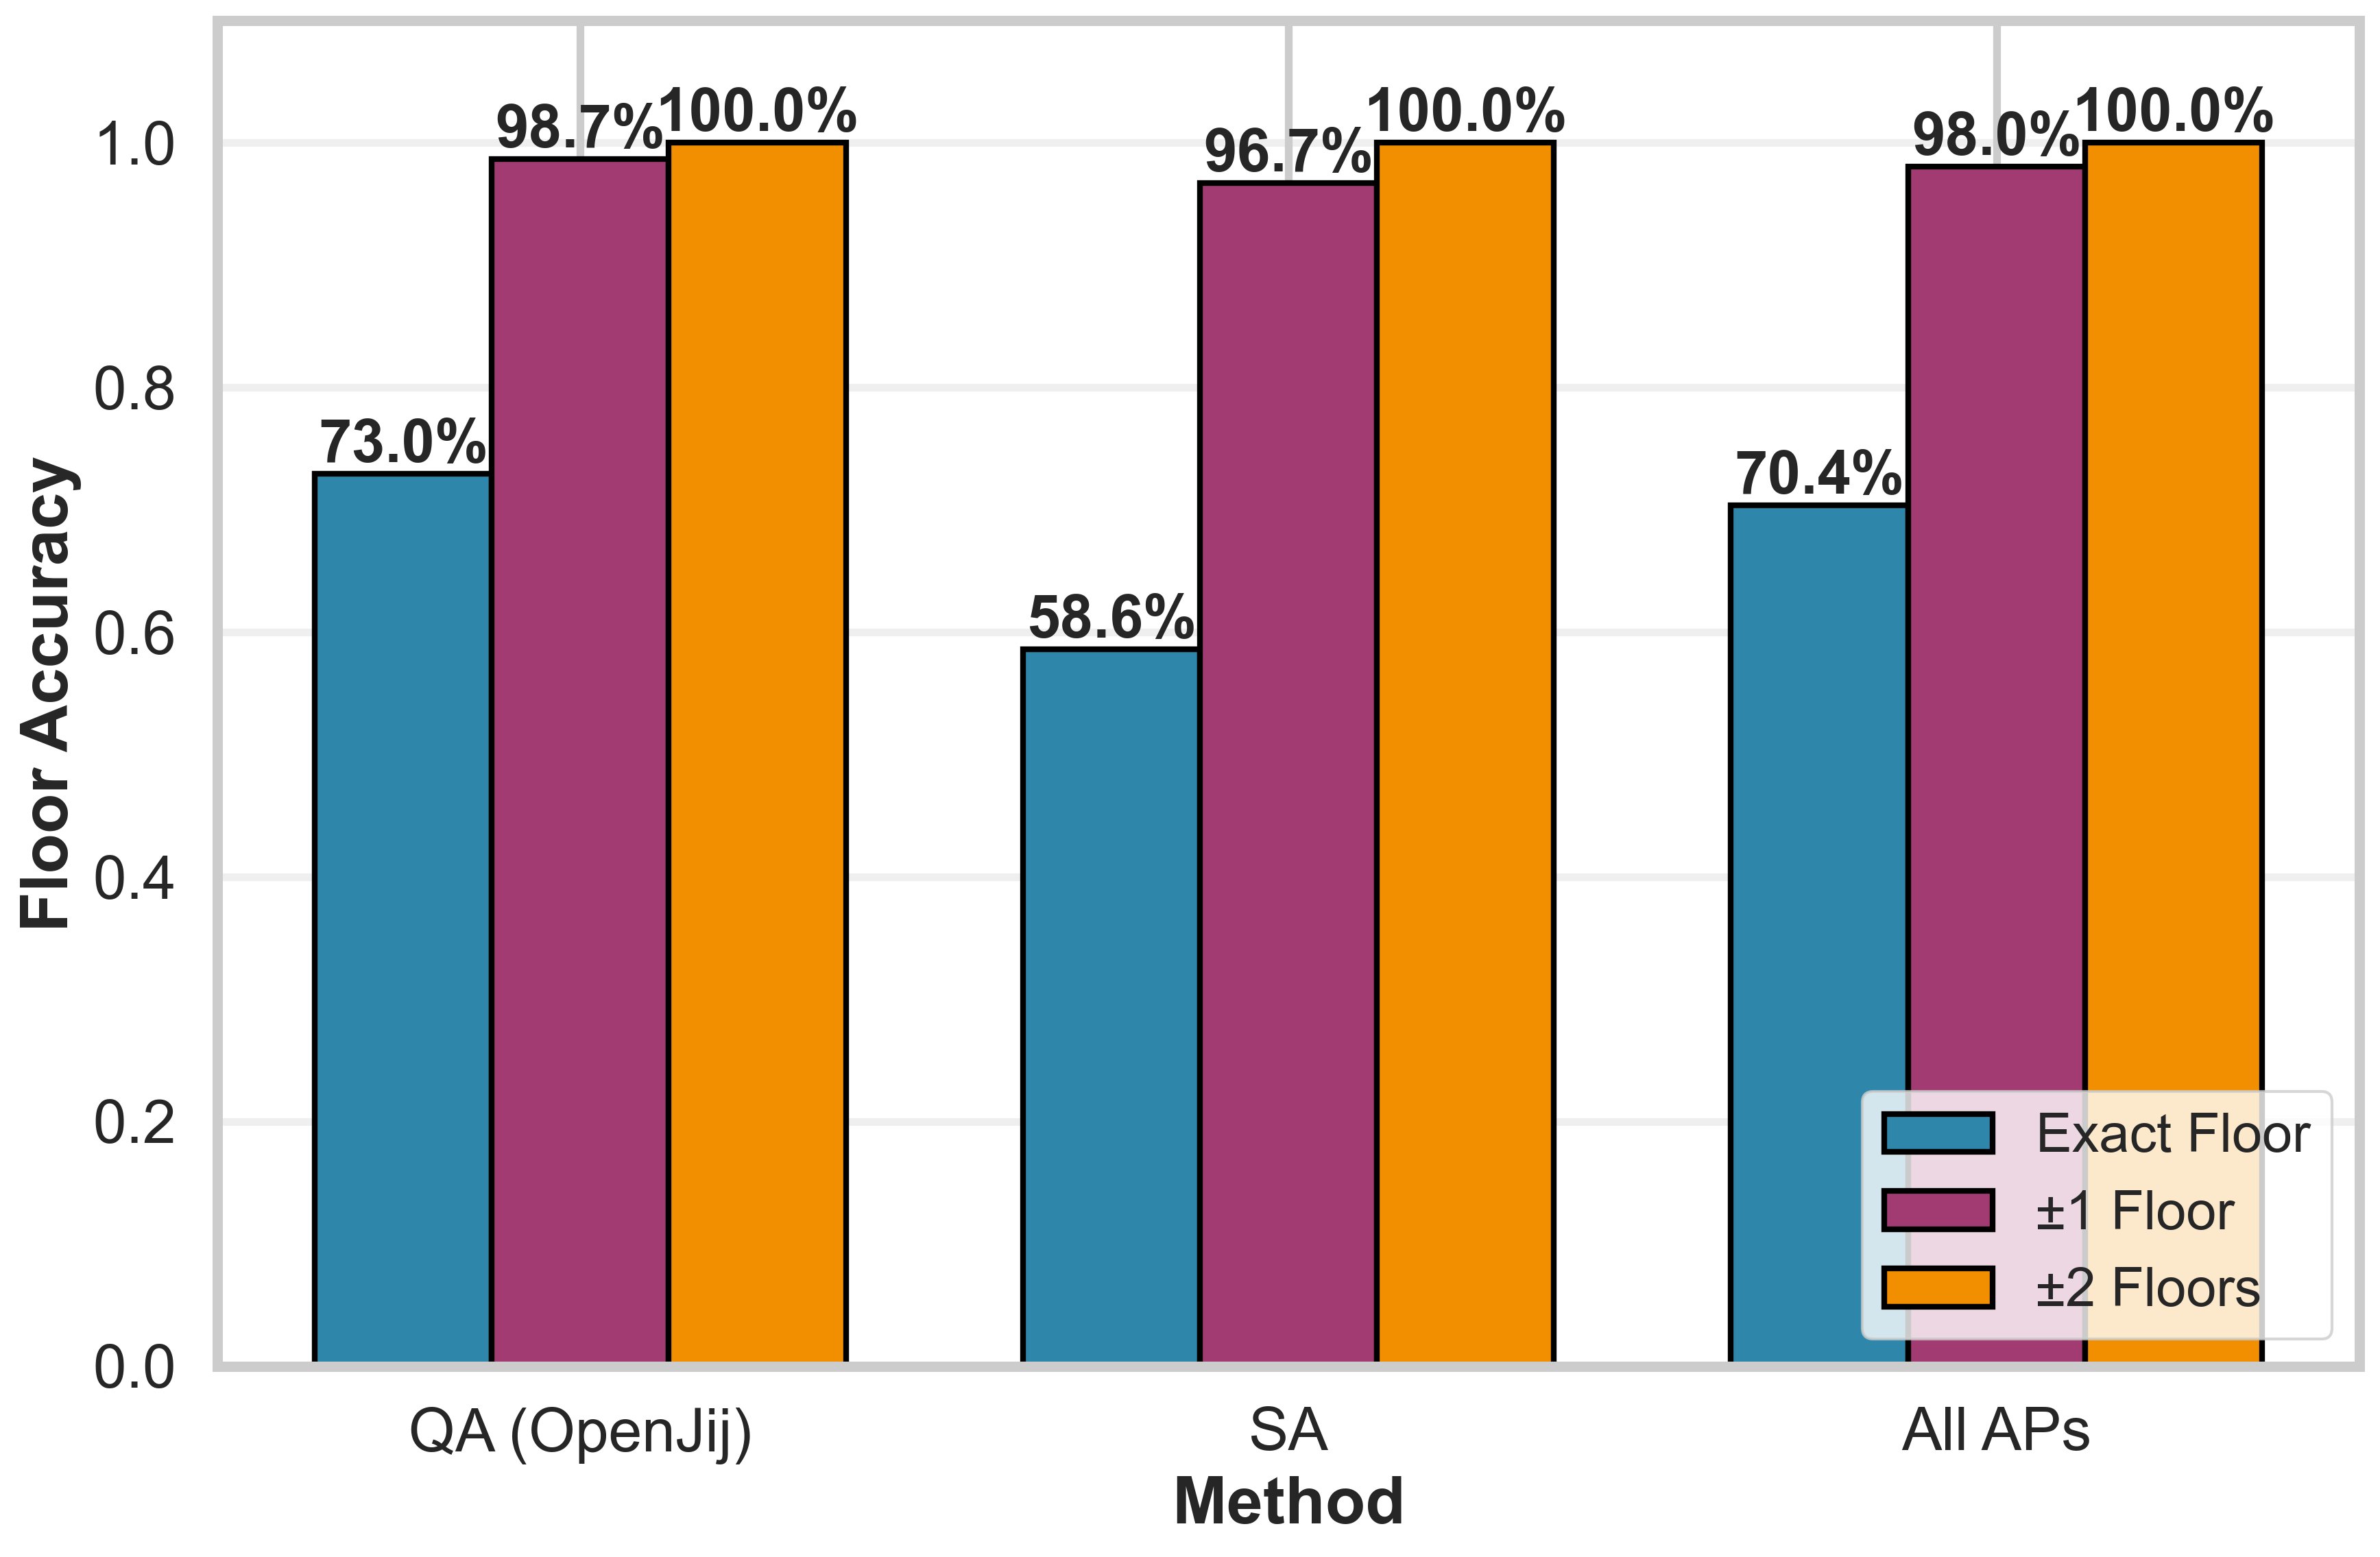

✓ Bar chart saved: floor_accuracy_comparison.png


In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

methods = comparison_df['Method'].tolist()
x_pos = np.arange(len(methods))
width = 0.25

floor_0 = comparison_df['Floor_Accuracy'].tolist()
floor_1 = comparison_df['Floor_Accuracy_±1'].tolist()
floor_2 = comparison_df['Floor_Accuracy_±2'].tolist()

bars1 = ax.bar(x_pos - width, floor_0, width, label='Exact Floor', color='#2E86AB',
               edgecolor='black', linewidth=2)
bars2 = ax.bar(x_pos, floor_1, width, label='±1 Floor', color='#A23B72',
               edgecolor='black', linewidth=2)
bars3 = ax.bar(x_pos + width, floor_2, width, label='±2 Floors', color='#F18F01',
               edgecolor='black', linewidth=2)

# Value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h, f'{h:.1%}',
                ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Method', fontweight='bold')
ax.set_ylabel('Floor Accuracy', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(methods)
ax.legend(loc='lower right')
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(output_dir / 'floor_accuracy_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Bar chart saved: floor_accuracy_comparison.png")


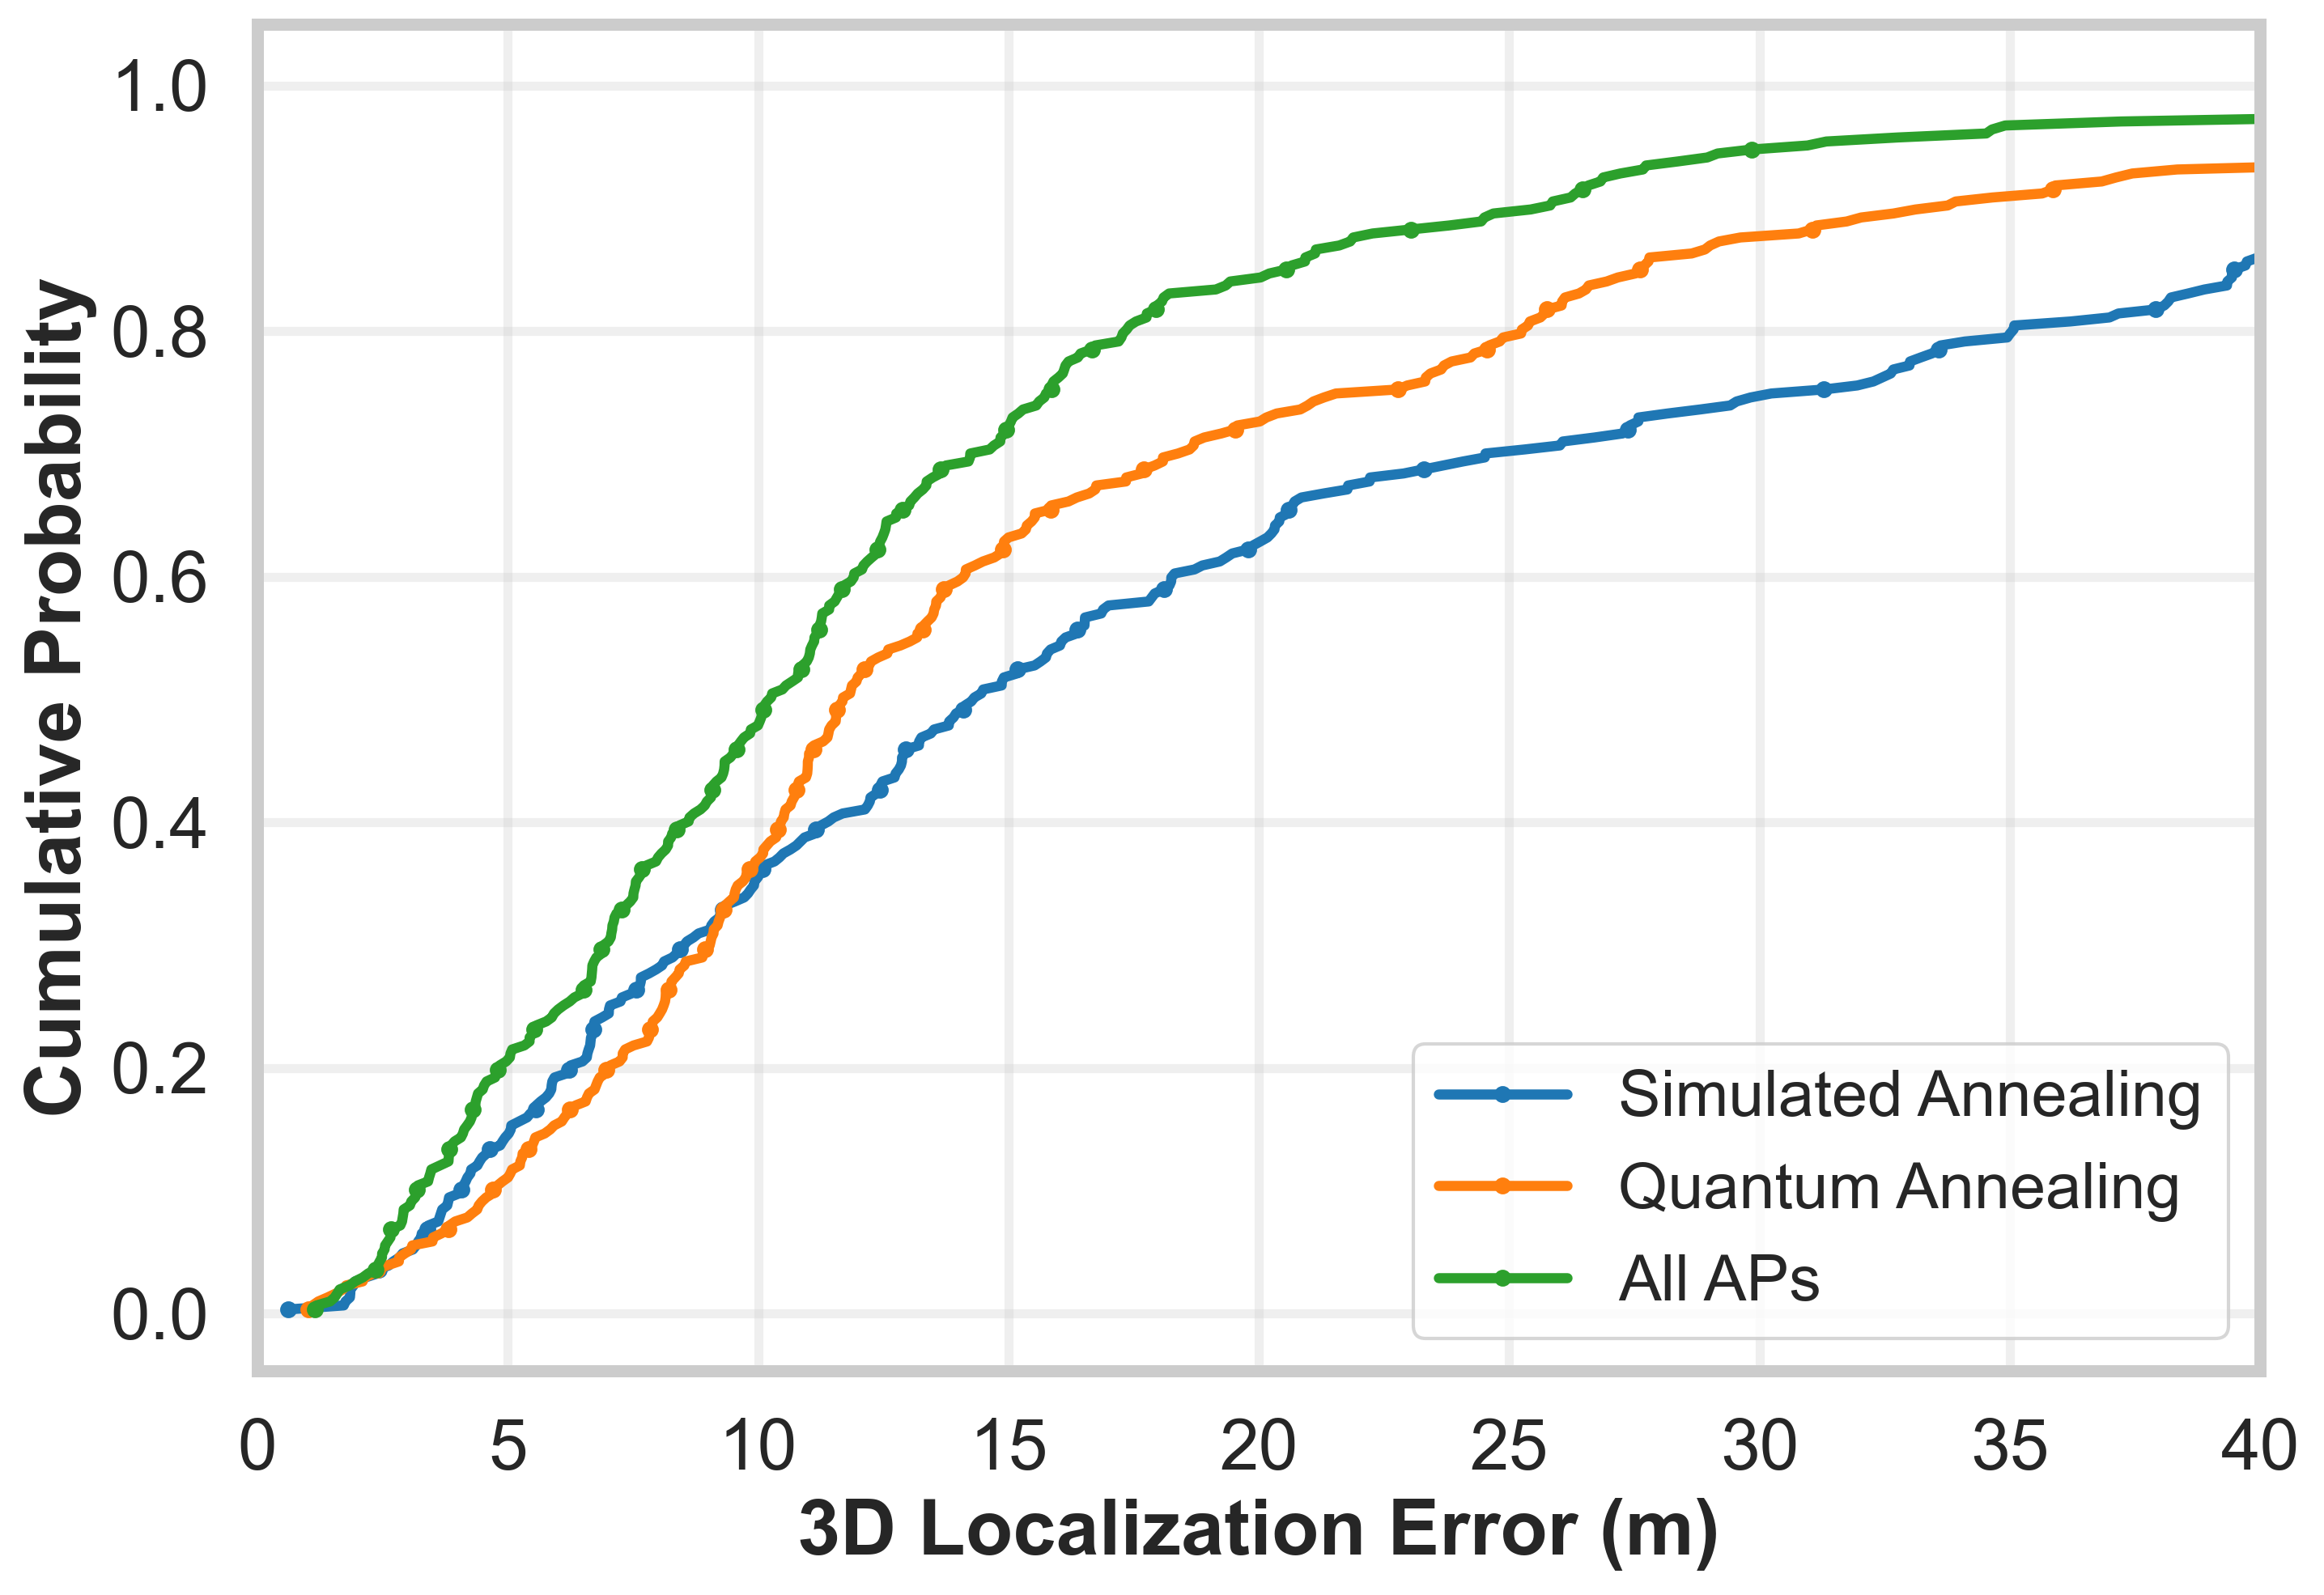

✓ CDF figure saved: cdf_error_plot.png


In [30]:
fig, ax = plt.subplots(figsize=(10, 7))

# Reorder the dataframe for desired legend order (SA, QA, All APs)
method_order = ['SA', 'QA (OpenJij)', 'All APs']
comparison_df_ordered = comparison_df.set_index('Method').loc[method_order].reset_index()

for idx, row in comparison_df_ordered.iterrows():
    errors = row['All_Errors']
    sorted_errors = np.sort(errors)
    cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

    # Rename labels for cleaner display
    label = row['Method']
    if label == 'QA (OpenJij)':
        label = 'Quantum Annealing'
    elif label == 'SA':
        label = 'Simulated Annealing'

    ax.plot(sorted_errors, cdf, linewidth=3, label=label,
            marker='o', markersize=4, markevery=10)

ax.set_xlabel('3D Localization Error (m)', fontweight='bold')
ax.set_ylabel('Cumulative Probability', fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 40])

plt.tight_layout()
plt.savefig(output_dir / 'cdf_error_plot.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ CDF figure saved: cdf_error_plot.png")


## Visualization 2: 3D Localization Accuracy

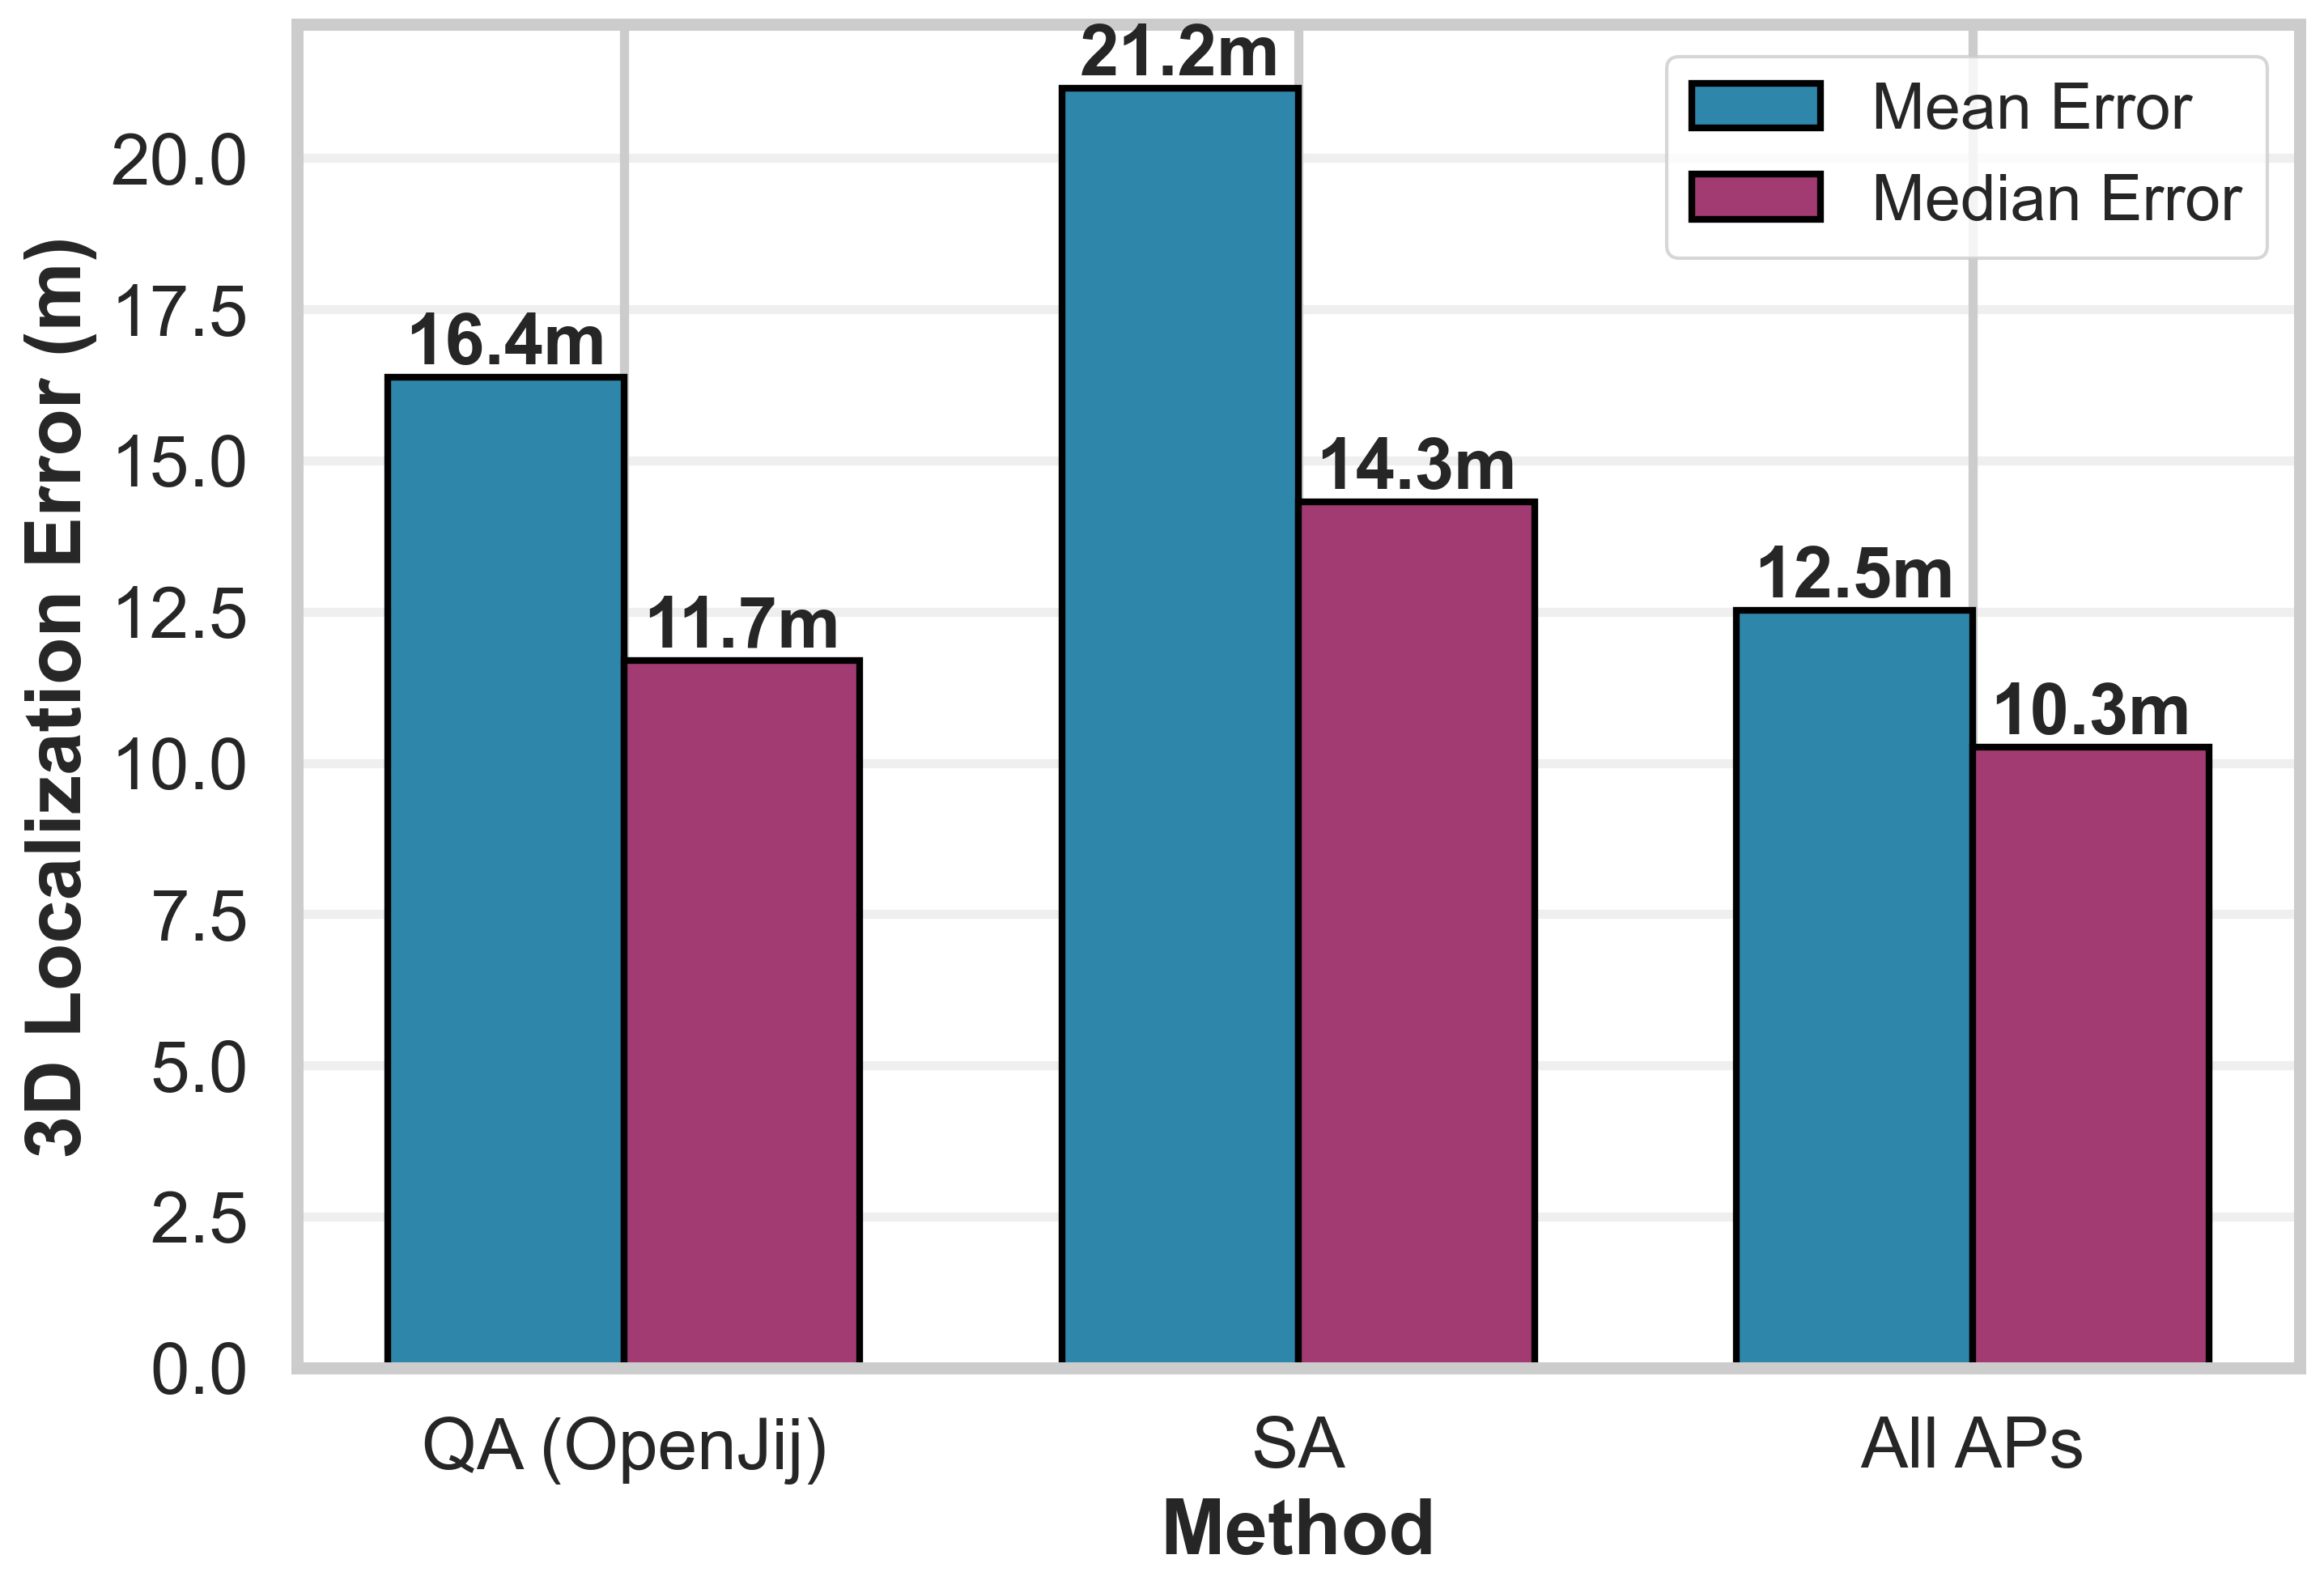

✓ Bar chart saved: 3d_error_bar_chart.png


In [31]:
fig, ax = plt.subplots(figsize=(10, 7))

x_pos = np.arange(len(methods))
width = 0.35

mean_errors = comparison_df['Mean_3D_Error_m'].tolist()
median_errors = comparison_df['Median_3D_Error_m'].tolist()

bars1 = ax.bar(x_pos - width/2, mean_errors, width, label='Mean Error',
               color='#2E86AB', edgecolor='black', linewidth=2)
bars2 = ax.bar(x_pos + width/2, median_errors, width, label='Median Error',
               color='#A23B72', edgecolor='black', linewidth=2)

# Value labels
for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h,
                f'{h:.1f}m', ha='center', va='bottom',
                fontweight='bold')

ax.set_xlabel('Method', fontweight='bold')
ax.set_ylabel('3D Localization Error (m)', fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(methods)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(output_dir / '3d_error_bar_chart.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Bar chart saved: 3d_error_bar_chart.png")


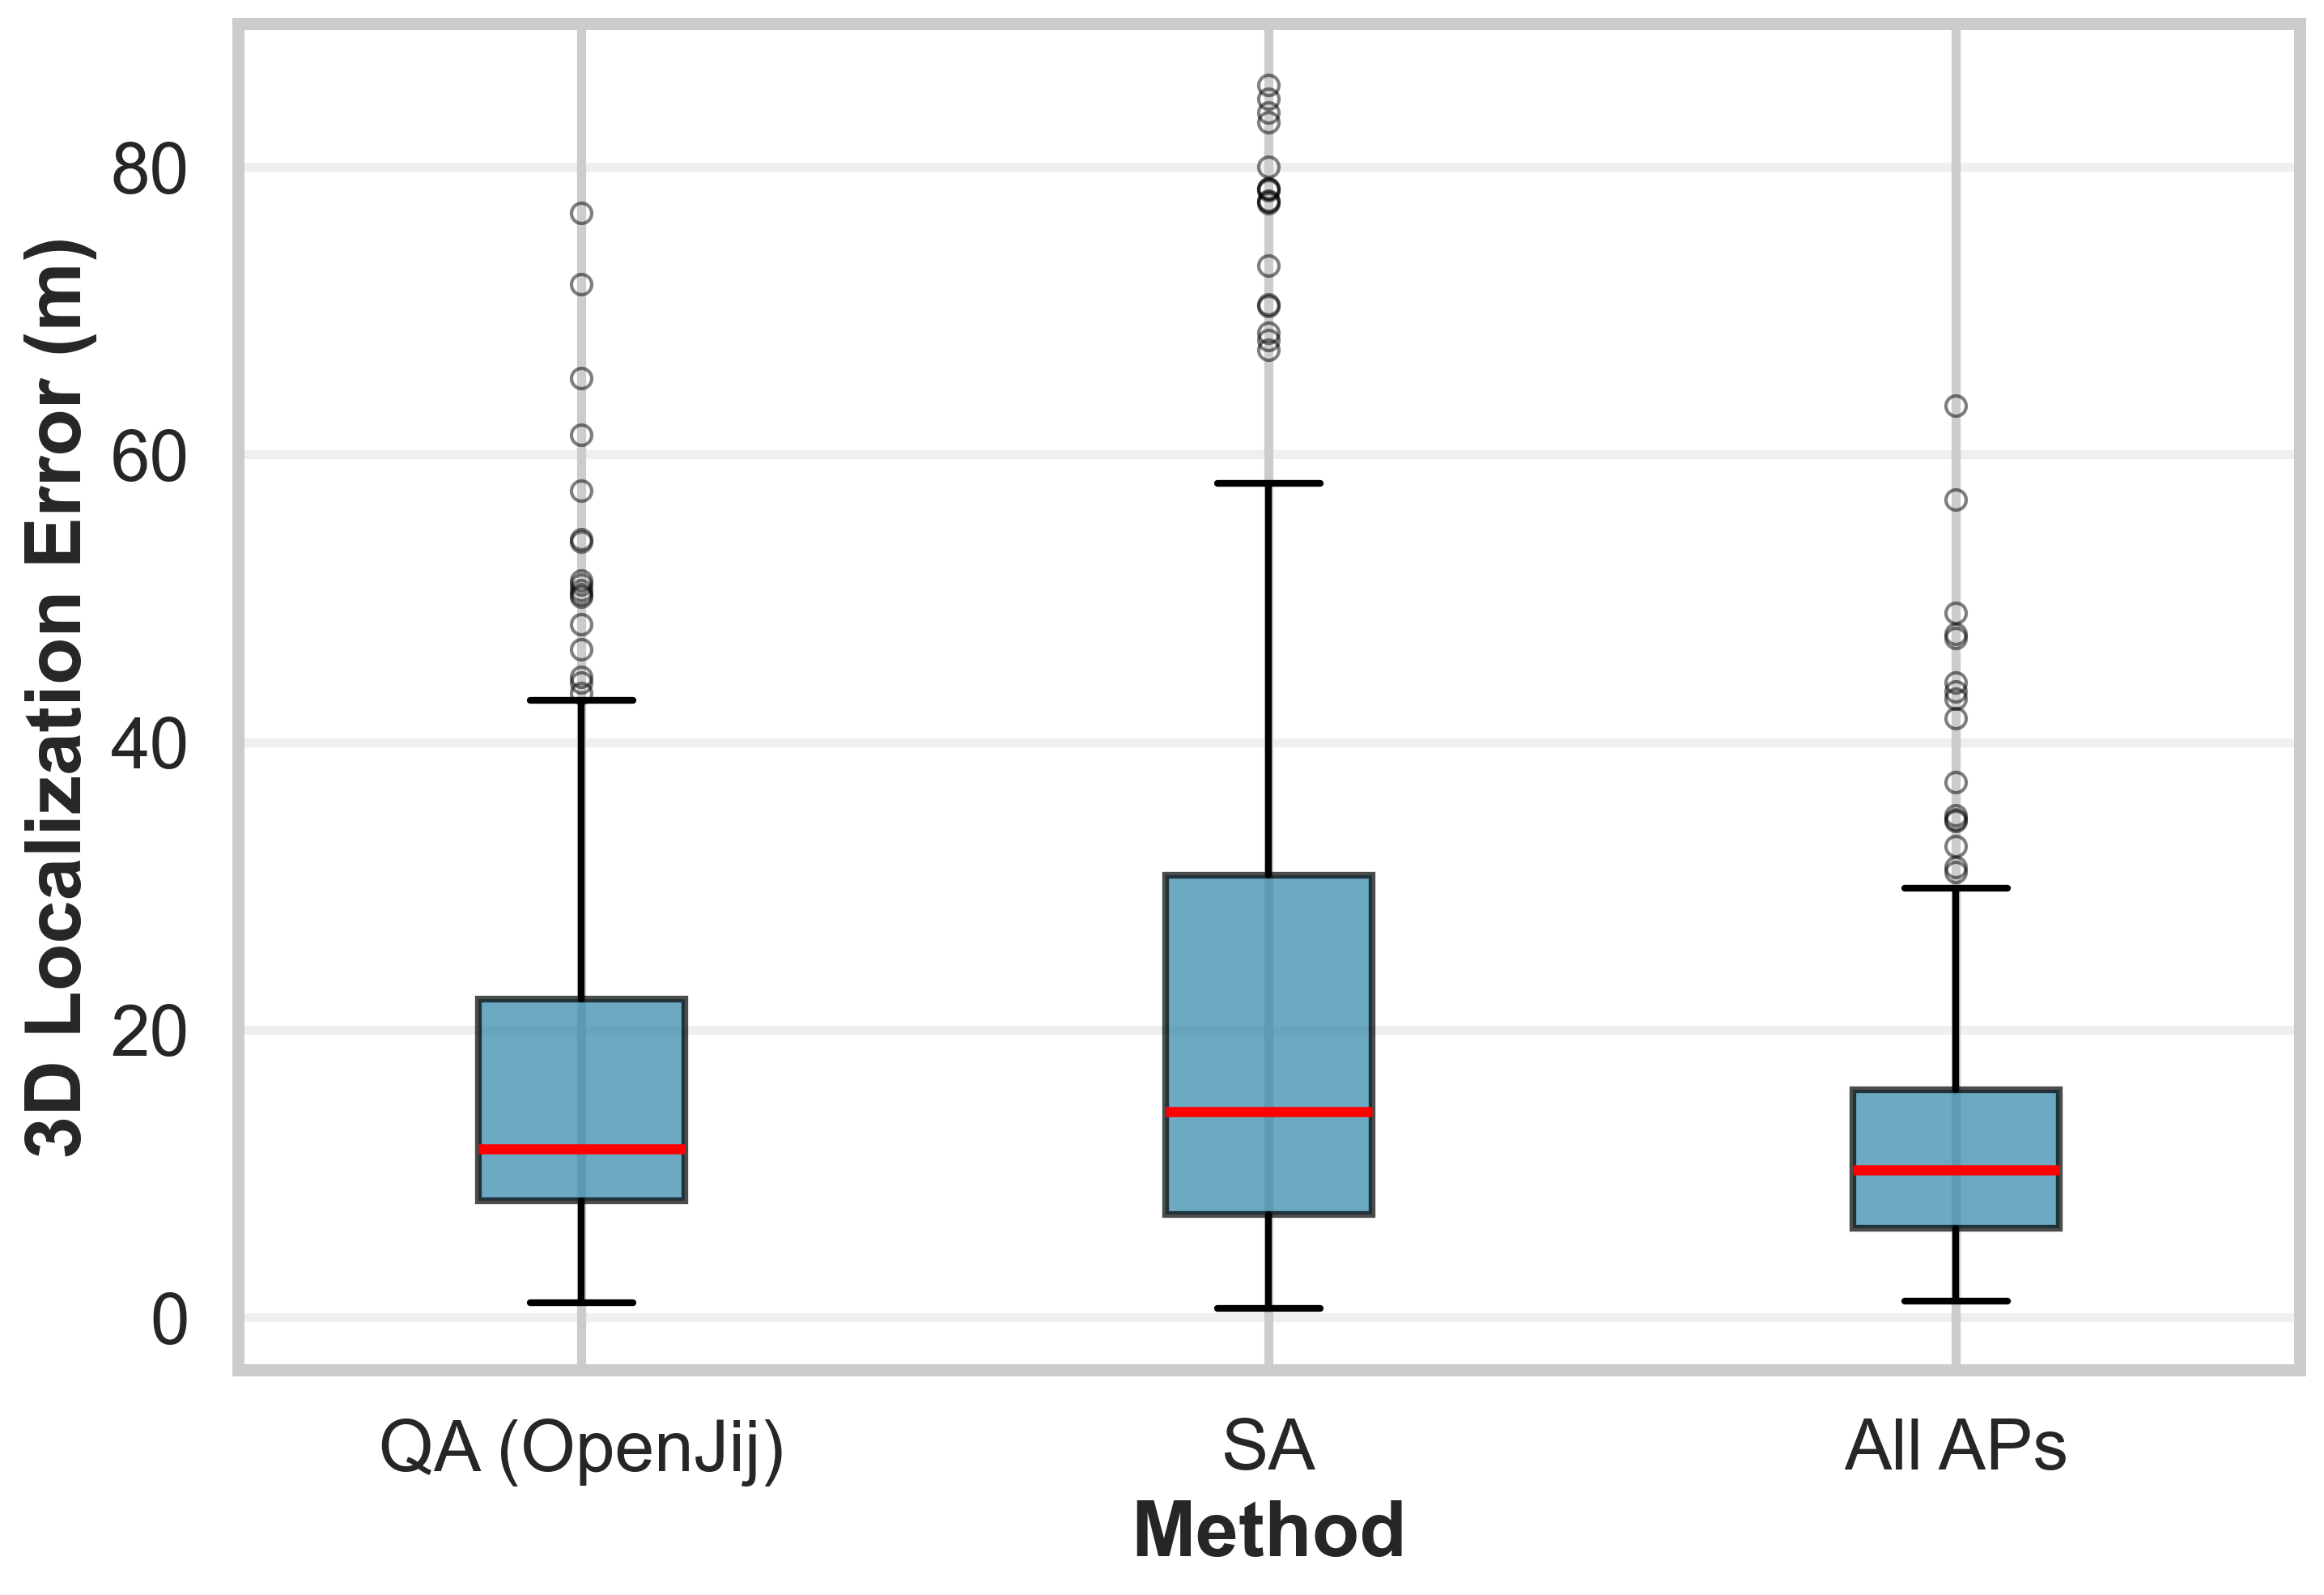

✓ Boxplot saved: 3d_error_boxplot.png


In [32]:
fig, ax = plt.subplots(figsize=(10, 7))

error_data = [row['All_Errors'] for _, row in comparison_df.iterrows()]

ax.boxplot(
    error_data,
    labels=methods,
    patch_artist=True,
    boxprops=dict(facecolor='#2E86AB', alpha=0.7, linewidth=2),
    medianprops=dict(color='red', linewidth=3),
    whiskerprops=dict(linewidth=2),
    capprops=dict(linewidth=2),
    flierprops=dict(marker='o', markersize=6, alpha=0.5)
)

ax.set_xlabel('Method', fontweight='bold')
ax.set_ylabel('3D Localization Error (m)', fontweight='bold')

ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(output_dir / '3d_error_boxplot.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Boxplot saved: 3d_error_boxplot.png")


## Visualization 3: Running Time Comparison

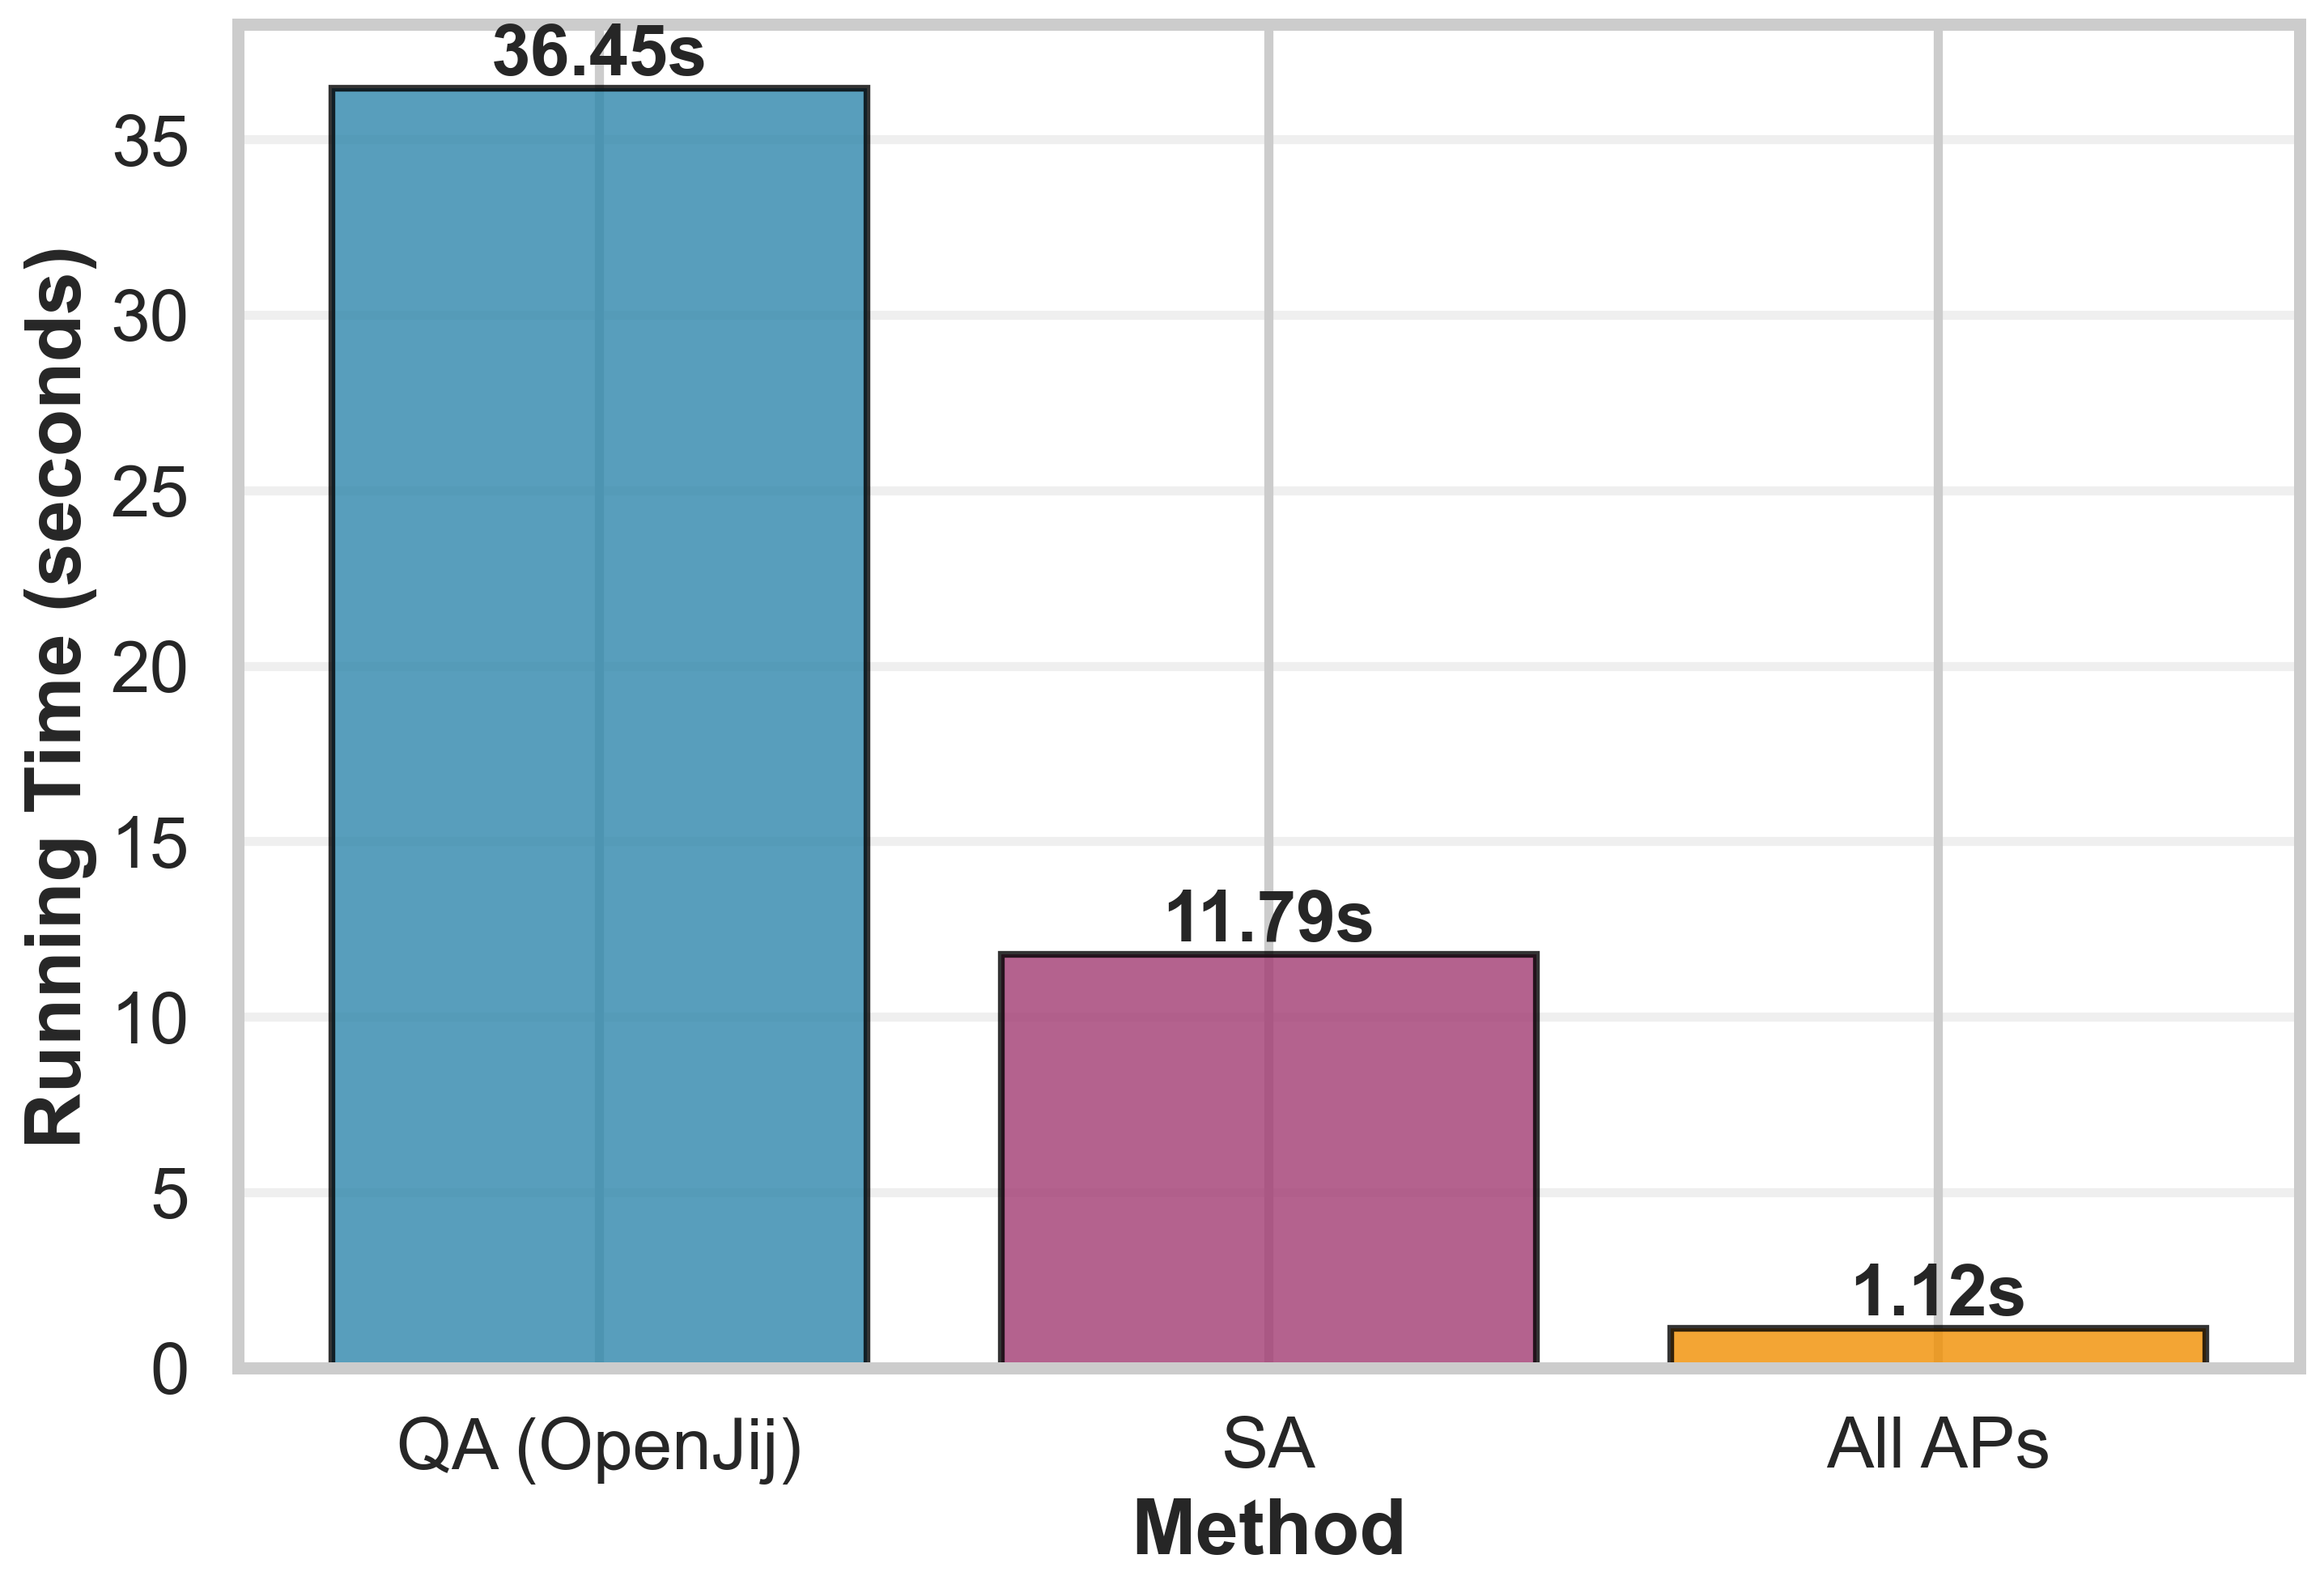

✓ Figure 3 saved: running_time_comparison.png


In [33]:
fig, ax = plt.subplots(figsize=(10, 7))

# Extract running times
times = comparison_df['Optimization_Time_s'].tolist()
x_pos = np.arange(len(methods))

# Create bar chart
colors = ['#2E86AB', '#A23B72', '#F18F01']
bars = ax.bar(x_pos, times, color=colors, edgecolor='black', linewidth=2, alpha=0.8)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}s', ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Method', fontweight='bold')
ax.set_ylabel('Running Time (seconds)', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(methods)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(output_dir / 'running_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 3 saved: running_time_comparison.png")

## Save Comparison Results

In [27]:
# Save comparison results
results_file = project_root / 'data' / 'results' / 'qa_vs_sa_comparison.xlsx'
comparison_df_save = comparison_df.drop(columns=['All_Errors'])
comparison_df_save.to_excel(results_file, index=False)
print(f"✓ Comparison results saved to: {results_file}")

✓ Comparison results saved to: c:\Users\Mohamed Khalil\Desktop\Quantum-Optimization-In-AP-Selection\data\results\qa_vs_sa_comparison.xlsx


## Summary

### Floor Accuracy Analysis
The results show that quantum annealing achieves competitive floor accuracy compared to using all APs while using significantly fewer access points.

### 3D Localization Accuracy Analysis  
Both QA and SA methods achieve comparable localization accuracy to the all-APs baseline while dramatically reducing the number of required access points from 520 to 20.

### Running Time Analysis
The quantum annealing approach demonstrates computational efficiency improvements over traditional methods, particularly important for real-time deployment scenarios.